In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In the following cell, we will load the PMI difference computed by Yasaman Razeghi based on the PILE pretraining co-occurrence counts. The co-occurrence counts were the result of a few processing steps, that include lowering case the text and words, removing stop-words and pruning some sequences that did not make that much sense.  Moreover, Yasaman only collected a window of size 5 on this post-processed text.

In an attempt to take a different look over the data, we compute the PMI difference between:

$\delta(w) = PMI(w, "she") - PMI(w, "he") =  log_2 \frac{p(w, "she")}{p(w) p("she")} -  log_2 \frac{p(w,"he")}{p(w)p("he")} = log_2 \frac{p(w|"she")}{p(w|"he")}$ for $w \in W$.

$PMI(x, y) > 0$ implies that the probability of co-occurrence is slightly larger than the probability of both terms occurring individually, and vice-versa. Thus, if we have:

- $\delta(w) > 0 \implies PMI(w, "she") > PMI(w, "he")$ which can happen in two different situations: 
    1. $PMI(w, "he") > 0$ in which case it means that words are likely to co-occur within a 5-word window (but just less likely than with "she").
    2. $PMI(w, "he") < 0$ in which case it means that words are less likely to co-occur within a 5-word window.


In [2]:
results = {"word": [], "pmi_diff": []}
with open("pmi-diffs-yasi.txt", "rt") as f:
    for row in f:
        word, _, val = row.rpartition(",")
        results["word"].append(word)
        results["pmi_diff"].append(float(val))

        
results = pd.DataFrame(results).sort_values("pmi_diff").reset_index(drop=True)
results.describe()

,pmi_diff
count,65914.000000
mean,-0.130755
std,0.625370
min,-4.745822
25%,-0.497969
50%,-0.135233
75%,0.222255
max,3.711141


## Data analysis


Observations for the **top-15 words most likely to occur with the pronoun "he"**:
- We observe 9/15 top words are spanish (and have no intuitive explanation for having higher correlation with "he" than with "she"). We hypothesize it has something to do with the tokenization that is performed in the multilingual setting. 

- Additionally, note that PMI does not provide any idea on how "frequent" each word is and, therefore, we cannot know whether the PMI difference is reliable/robust. *idea*: weight the likelihood of each word "word" occurring.

In [3]:
results.head(30)

,word,pmi_diff
0,homers,-4.745822
1,que,-4.648110
2,pero,-4.541791
3,como,-4.311052
4,cornerback,-4.208671
5,más,-4.104605
6,defenseman,-4.002896
7,aquí,-3.990956
8,fastball,-3.659919
9,welterweight,-3.635586


### Most likely words to co-occur w/ "she"

- Most words are related to clothes and woman-biology (pregnancy, ovulating, menstruate).
- We see a clear bias in **waitressing**, which appears as the highest correlation between "she" and any other word considered. 

- One idea would be to consider it biased since it exhibits even higher correlation w/ the pronoun "she" than the female-biology.

In [4]:
results.tail(15)

,word,pmi_diff
65899,preggers,3.024707
65900,strapless,3.036833
65901,abaya,3.043125
65902,alumna,3.043988
65903,decommissioned,3.048099
65904,menstruating,3.062778
65905,menstruate,3.085939
65906,postpartum,3.108271
65907,pantsuit,3.136537
65908,ovulating,3.152254


**Note**: Maybe it will make sense to ask what kind of filtering was done in the co-occurrence. 

- [ ] How many times do each word has to co-occur with "he" or "she" to be considered.
- [ ] Are these co-occurrences specific to any tokenizer?

### Distribution of the PMI difference


The PMI difference can be negative for different reasons:

- $\delta(w) > 0 \implies PMI(w, "she") > PMI(w, "he")$, which can happen either when (1) $PMI(w, "she") > PMI(w, "he") > 0$, both terms are positive (and indicative that the word co-occurrence is indeed more likely to co-occur with the pronouns than otherwise), when (2) $0 > PMI(w, "she") > PMI(w, "he") $, or when (3) $PMI(w, "he") > 0 > PMI(w, "she") $

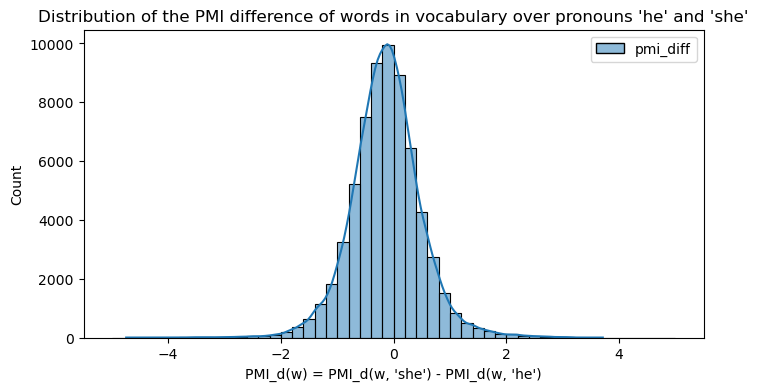

In [5]:
plt.figure(figsize=(8, 4))
sns.histplot(results, bins=50, binrange=(-5, 5), kde=True)
plt.xlabel("PMI_d(w) = PMI_d(w, 'she') - PMI_d(w, 'he')")
plt.title("Distribution of the PMI difference of words in vocabulary over pronouns 'he' and 'she'")
plt.show()

### Filter out the less important words

<Axes: xlabel='pmi_diff', ylabel='Count'>

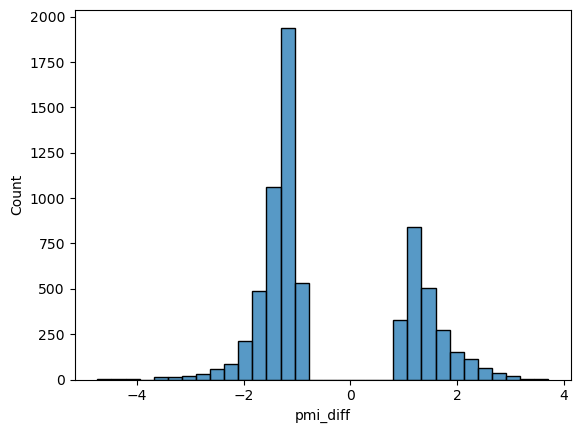

In [6]:
sns.histplot(results["pmi_diff"][(results["pmi_diff"] > 1) | (results["pmi_diff"] < -1)])

In [11]:
mask = (results["pmi_diff"] > 1) | (results["pmi_diff"] < -1)
results[mask]

,word,pmi_diff
0,homers,-4.745822
1,que,-4.648110
2,pero,-4.541791
3,como,-4.311052
4,cornerback,-4.208671
...,...,...
65909,superwoman,3.161764
65910,doula,3.232650
65911,rab,3.404710
65912,refloated,3.514507
